In [290]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
'''

Use this cell for planning out approach, notes of what has worked/what doesn't work, status of code for next time, etc


The goal of this is to measure the density of vacancies created at different depths within the sample. This will then also bleed 
into measuring the track width at different depths of the sample - that will be a part 2 most likely and will build off of 
studying the vacancies.

What do we need to know in order to find new vacanies and compare it to the original value - well, 0?

    - the crystal spacing of the material being studied
    - if I can export out the particles that are highlighted in OVITO for being kicked out of their original spacing
    
    
Things to take into account:
    - need to delete the outermost particles since they are naturally considered out of the original position because of 
    how LAMMPS/OVITO works 
    - finding the 1 sigma confidence interval on said measurements
    - compare these against the data we have (note I need to seriously kick up the energy of the inbound ion before I 
    can get to this point)


Steps to accomplish to get this working:
    - load in data and ensure it is visible/makes sense
    - delete outside atoms so they don't impact statistics
    - find a way to quantify the number of vacancies there are at one timestep
    - find the vacancy density at a region
    - find the +- 1 sigma confidence interval on these measurements
    - make a plot for varying track depths tracking the vacancy density at that particular region
    - find the track length and width vs depth into sample
    - ensure that there aren't discrepancies between track length calculations and vacancy density calculations


'''

### Step 1: Get Data Loaded and Visualized

In [243]:
data = pd.read_csv('test_vacancy_file2.txt', sep = " ")
data

,step,type,x,y,id,z,coordination
0,5000.0,1,-123.322,80.465,319,-64.644,2
1,5000.0,1,-123.324,80.480,320,-59.199,2
2,5000.0,1,-123.330,80.493,321,-53.759,2
3,5000.0,1,-123.337,80.504,322,-48.324,2
4,5000.0,1,-123.343,80.514,323,-42.892,2
...,...,...,...,...,...,...,...
786003,9800.0,1,14.789,12.779,387108,0.175,3
786004,9800.0,2,15.681,3.617,387899,1.481,0
786005,9800.0,1,16.062,2.242,387901,2.303,3
786006,9800.0,1,14.824,4.363,387942,0.300,2


In [253]:
steps = np.unique(data['step'].values)

datainit = data[data['step'] == steps[0]].copy()
datainit = datainit.sort_values(by = 'id')
datafinal = data[data['step'] == steps[-1]].copy()
datafinal = datafinal.sort_values(by = 'id')
datainit

,step,type,x,y,id,z,coordination
0,5000.0,1,-123.322,80.465,319,-64.644,2
1,5000.0,1,-123.324,80.480,320,-59.199,2
2,5000.0,1,-123.330,80.493,321,-53.759,2
3,5000.0,1,-123.337,80.504,322,-48.324,2
4,5000.0,1,-123.343,80.514,323,-42.892,2
...,...,...,...,...,...,...,...
15334,5000.0,1,19.315,-4.432,387855,0.932,3
15335,5000.0,2,15.363,3.626,387899,1.437,0
15336,5000.0,1,15.739,2.255,387901,2.269,3
15337,5000.0,1,14.497,4.371,387942,0.262,2


Text(0, 0.5, 'Z')

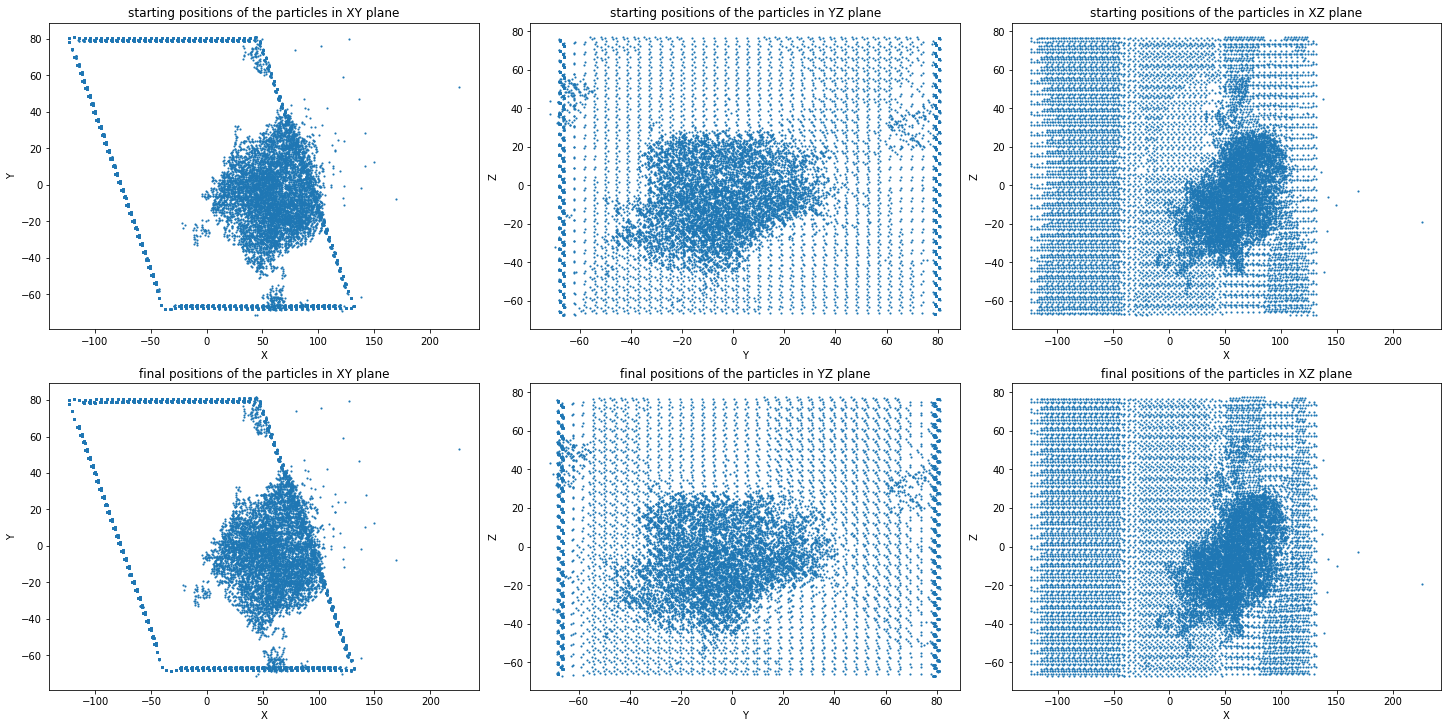

In [252]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)

axes[0,0].scatter(datainit['x'].values, datainit['y'].values, s = 5, marker = '.')
axes[0,0].set_title('starting positions of the particles in XY plane')
axes[0,0].set_xlabel('X')
axes[0,0].set_ylabel('Y')

axes[0,1].scatter(datainit['y'].values, datainit['z'].values, s = 5, marker = '.')
axes[0,1].set_title('starting positions of the particles in YZ plane')
axes[0,1].set_xlabel('Y')
axes[0,1].set_ylabel('Z')

axes[0,2].scatter(datainit['x'].values, datainit['z'].values, s = 5, marker = '.')
axes[0,2].set_title('starting positions of the particles in XZ plane')
axes[0,2].set_xlabel('X')
axes[0,2].set_ylabel('Z')

axes[1,0].scatter(datafinal['x'].values, datafinal['y'].values, s = 5, marker = '.')
axes[1,0].set_title('final positions of the particles in XY plane')
axes[1,0].set_xlabel('X')
axes[1,0].set_ylabel('Y')

axes[1,1].scatter(datafinal['y'].values, datafinal['z'].values, s = 5, marker = '.')
axes[1,1].set_title('final positions of the particles in YZ plane')
axes[1,1].set_xlabel('Y')
axes[1,1].set_ylabel('Z')

axes[1,2].scatter(datafinal['x'].values, datafinal['z'].values, s = 5, marker = '.')
axes[1,2].set_title('final positions of the particles in XZ plane')
axes[1,2].set_xlabel('X')
axes[1,2].set_ylabel('Z')

### Step 2: Cut-off Outer Edge Particles

#### Note: this will be particular for this sized quartz sample - change the following code for whatever fiducial cuts are needed in the future

In [254]:
''' perform cuts on the slopes of the quartz'''

def find_line(x1, x2, y1, y2):
    slope = (y2 - y1) / (x2 - x1) 
    intercept = y1 - (slope * x1)  
    return slope, intercept

y_min, y_max = -68.916, 81.08
x_minl, x_maxl = -123.366, -44.019
x_minr, x_maxr = 44.938, 131.493

quartz_slopel, quartz_interceptl = find_line(x_maxl, x_minl, y_max, y_min)
quartz_sloper, quartz_interceptr = find_line(x_maxr, x_minr, y_max, y_min)
quartz_slopel, quartz_sloper = -quartz_slopel, -quartz_sloper

expected_y_left = (quartz_slopel) * data['x'] + (quartz_interceptl)  #actually corresponds to right side
expected_y_right = quartz_sloper * data['x'] + (quartz_interceptr + 20)     #actually corresponds to left side

filt_data = data[(data['y'] <= expected_y_left) & (data['y'] >= expected_y_right)]
# Print results
print(f"Original data size: {len(data)}")
print(f"Filtered data size: {len(filt_data)}")

Original data size: 786008
Filtered data size: 532340


In [255]:
''' perform cuts on the y-axis '''

filt_data = filt_data[(filt_data['y'] <= y_max - 3) & (filt_data['y'] >= y_min + 3)]
print(f"Original data size: {len(data)}")
print(f"Filtered data size: {len(filt_data)}")

Original data size: 786008
Filtered data size: 294075


In [256]:
#recreate the dataframes with the filtered data

steps = np.unique(filt_data['step'].values)

datainit_cut = filt_data[filt_data['step'] == steps[0]].copy()
datainit_cut = datainit_cut.sort_values(by = 'id')
datafinal_cut = filt_data[filt_data['step'] == steps[-1]].copy()
datafinal_cut = datafinal_cut.sort_values(by = 'id')
datainit_cut

,step,type,x,y,id,z,coordination
6334,5000.0,2,54.740,-64.945,35423,49.755,1
6452,5000.0,2,57.750,-65.680,35998,32.094,1
6461,5000.0,2,59.973,-64.910,36017,39.051,1
6465,5000.0,2,61.923,-63.363,36023,46.734,1
6466,5000.0,2,57.809,-65.194,36025,48.203,1
...,...,...,...,...,...,...,...
15334,5000.0,1,19.315,-4.432,387855,0.932,3
15335,5000.0,2,15.363,3.626,387899,1.437,0
15336,5000.0,1,15.739,2.255,387901,2.269,3
15337,5000.0,1,14.497,4.371,387942,0.262,2


Text(0, 0.5, 'Z')

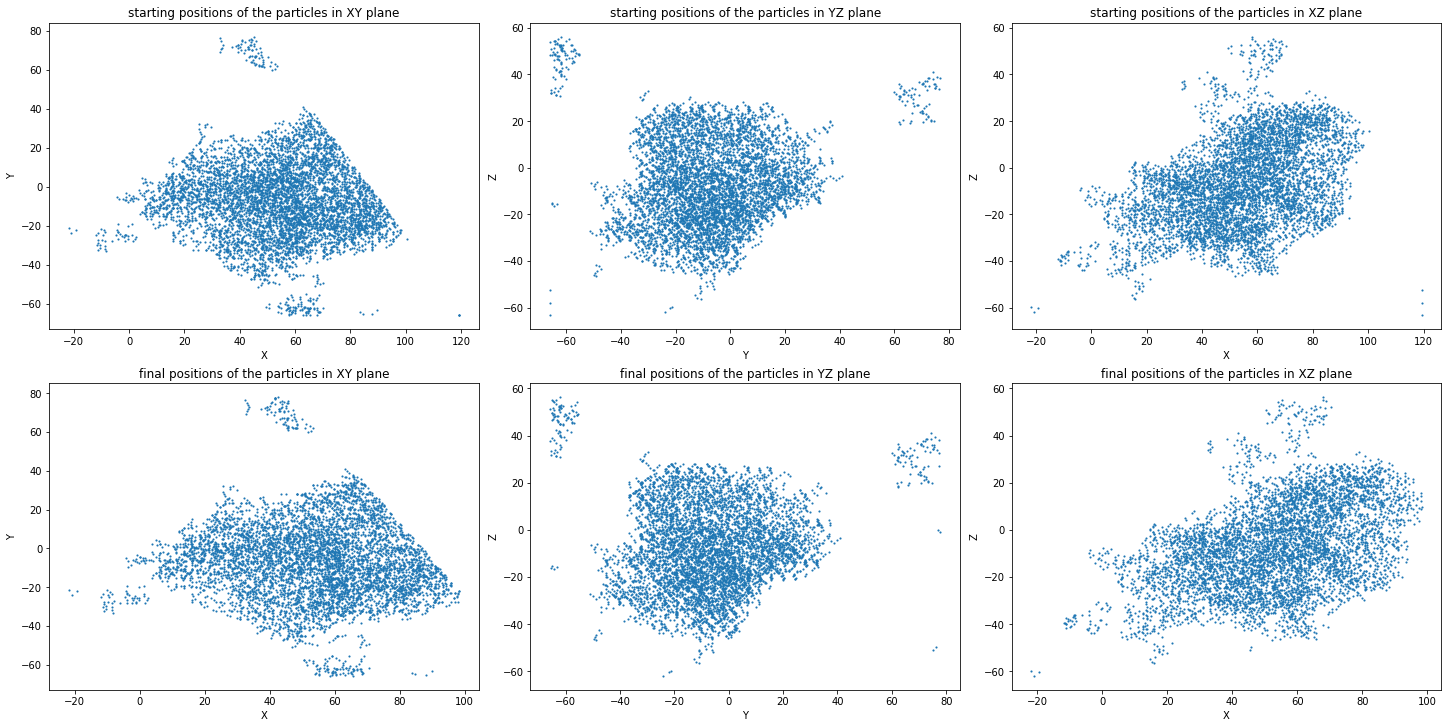

In [451]:
#print out the plots again to ensure data was properly cut-off

fig, axes = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)

axes[0,0].scatter(datainit_cut['x'].values, datainit_cut['y'].values, s = 5, marker = '.')
axes[0,0].set_title('starting positions of the particles in XY plane')
axes[0,0].set_xlabel('X')
axes[0,0].set_ylabel('Y')

axes[0,1].scatter(datainit_cut['y'].values, datainit_cut['z'].values, s = 5, marker = '.')
axes[0,1].set_title('starting positions of the particles in YZ plane')
axes[0,1].set_xlabel('Y')
axes[0,1].set_ylabel('Z')

axes[0,2].scatter(datainit_cut['x'].values, datainit_cut['z'].values, s = 5, marker = '.')
axes[0,2].set_title('starting positions of the particles in XZ plane')
axes[0,2].set_xlabel('X')
axes[0,2].set_ylabel('Z')

axes[1,0].scatter(datafinal_cut['x'].values, datafinal_cut['y'].values, s = 5, marker = '.')
axes[1,0].set_title('final positions of the particles in XY plane')
axes[1,0].set_xlabel('X')
axes[1,0].set_ylabel('Y')

axes[1,1].scatter(datafinal_cut['y'].values, datafinal_cut['z'].values, s = 5, marker = '.')
axes[1,1].set_title('final positions of the particles in YZ plane')
axes[1,1].set_xlabel('Y')
axes[1,1].set_ylabel('Z')

axes[1,2].scatter(datafinal_cut['x'].values, datafinal_cut['z'].values, s = 5, marker = '.')
axes[1,2].set_title('final positions of the particles in XZ plane')
axes[1,2].set_xlabel('X')
axes[1,2].set_ylabel('Z')

### Step 3: Try to quantify number of vacancies

In [411]:
num_vacancies = [len(filt_data[filt_data['step'] == step]) for step in steps]
'''
it might just be this easy since once we get into the the core of the sample a vacancy arises when a particle is knocked out
there must be a vacancy left behind, but triple check with Emilie to make sure this is correct - otherwise modify 
'''

'\nit might just be this easy since once we get into the the core of the sample a vacancy arises when a particle is knocked out\nthere must be a vacancy left behind, but triple check with Emilie to make sure this is correct - otherwise modify \n'

### Step 4: Find vacancy density in one specific region

In [259]:
# units of dimensions are in angstroms
x_len = np.max(datafinal_cut['x'].values) - np.min(datafinal_cut['x'].values)
y_len = np.max(datafinal_cut['y'].values) - np.min(datafinal_cut['y'].values)
z_len = np.max(datafinal_cut['z'].values) - np.min(datafinal_cut['z'].values)

volume = (x_len) * (y_len) * (z_len) 
total_density = num_vacancies / volume
print(f"the total density of vacancies in the sample at time step {steps[-1]} is {total_density[0]:.6f} vacancies/angstroms") #done for each timestep 

the total density of vacancies in the sample at time step 9800.0 is 0.002947 vacancies/angstroms


In [260]:
''' basic generalized formula as of this moment to find vacancy density at a particular slice from yz-plane of desired thickness '''

def vacancy_vs_depth(data, start, end): #this works best for one timestep - can modify in the future if needed
    depth = start - end #starting and ending points specified, where start here is specified as the entrance on the right side
    vol = depth * y_len * z_len  # this takes into account a slice of the entire yz-plane at some depth in the x-direction
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result

In [435]:
x_start, x_end = np.max(filt_data['x'].values), 60
data_input1 = filt_data[filt_data['step'] == steps[0]]
data_input2 = filt_data[filt_data['step'] == steps[-1]]
data_input3 = filt_data[filt_data['step'] == steps[6]]
data_input4 = filt_data[filt_data['step'] == steps[3]]

result = vacancy_vs_depth(data_input, x_start, x_end)
print(f"vacancy density in sample at depth {x_start - x_end} angstroms at time step {steps[0]} is {result:.6f} vacancies/angstroms") #done for each timestep 

vacancy density in sample at depth 59.328 angstroms at time step 5000.0 is 0.005967 vacancies/angstroms


### Step 6: Make a plot for differing depths what are the predicted vacancy densities (with error to be added soon)

In [432]:
x_end_options = [80, 75, 70, 60, 50, 30, 10, -10]

result1 = [vacancy_vs_depth(data_input1, x_start, x_end) for x_end in x_end_options]
result2 = [vacancy_vs_depth(data_input2, x_start, x_end) for x_end in x_end_options]
result3 = [vacancy_vs_depth(data_input3, x_start, x_end) for x_end in x_end_options]
result4 = [vacancy_vs_depth(data_input4, x_start, x_end) for x_end in x_end_options]

/var/folders/8_/7cxg7b591zn267gy4zwgyw6h0000gn/T/ipykernel_25700/2523134396.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  result = num_vacancy / vol


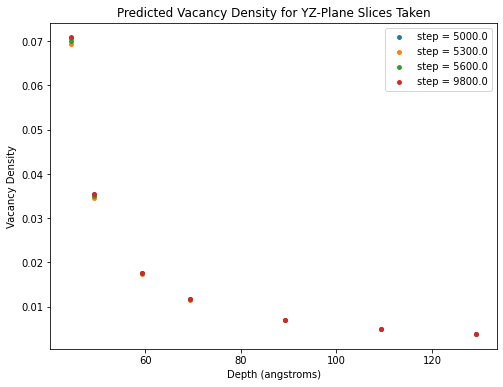

In [436]:
x_end_options = [80, 75, 70, 60, 50, 30, 10, -10]
x_values = [x_start - x for x in x_end_options]

fig = plt.figure(figsize=(8, 6))
plt.scatter(x_values, result1, label = f'step = {steps[0]}', s = 15)
plt.scatter(x_values, result4, label = f'step = {steps[3]}', s = 15)
plt.scatter(x_values, result3, label = f'step = {steps[6]}', s = 15)
plt.scatter(x_values, result2, label = f'step = {steps[-1]}', s = 15)
plt.title(f'Predicted Vacancy Density for YZ-Plane Slices Taken')
plt.xlabel('Depth (angstroms)')
plt.ylabel('Vacancy Density')
plt.legend(loc = 'best')

### Step 7: Try to find track width and length at different depths

In [422]:
''' 
current motivation here - find the closest particles in the entire 360 degree and define that as the boundary
is there someway to exploit the vacancy density done earlier to make this calculation easier?

the plot/information we want is track width (y) vs track depth (x)

recall vacancy definition:

def vacancy_vs_depth(data, start, end): 
    depth = start - end 
    vol = depth * y_len * z_len  
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result
    
recall - the gold ion is being shot along the x-axis headon into the y-axis and z-axis (obviously) on axis = 0 - use to advantage

so from this in theory we can simply start a distance finder for multiple points in a 2pi space from axis = 0 until it reaches a particle

'''

def find_spacing(end, y_ref, z_ref, data, sigma_y=0.1, sigma_z=0.1):
    depth = np.max(data['x'].values) - end  # Get the depth into the sample
    filtered_data = data[np.isclose(data['x'], depth, atol=0.2)]  # Allow slight tolerance for floating-point errors

    if filtered_data.empty:
        print(f"No particles found at x = {depth} (end = {end})")
        return [], [], [], []  # Return empty error lists as well

    degree_spacing = np.linspace(0, 360, 361)  # 0.1-degree increments

    yvalue, zvalue, width_at_x, error_at_x = [], [], [], []
    
    for theta in degree_spacing:
        theta_rad = np.radians(theta)

        dy = np.cos(theta_rad)
        dz = np.sin(theta_rad)

        # Compute radial distances
        distances = np.sqrt((filtered_data['y'] - y_ref)**2 + (filtered_data['z'] - z_ref)**2)
        
        if distances.empty:
            continue  # Skip this angle if no data is found
        
        # Find the minimum distance
        min_idx = np.argmin(distances)
        yvalue.append(filtered_data.iloc[min_idx]['y'])
        zvalue.append(filtered_data.iloc[min_idx]['z'])

        # Compute the error propagation
        distance = distances.iloc[min_idx]
        error_distance = np.sqrt(
            ((filtered_data.iloc[min_idx]['y'] - y_ref) / distance) ** 2 * sigma_y ** 2 +
            ((filtered_data.iloc[min_idx]['z'] - z_ref) / distance) ** 2 * sigma_z ** 2)
        
        error_at_x.append(error_distance)

    if yvalue and zvalue:
        max_distance = np.min(distances)
        width_at_x.append(max_distance)  # Store the min radius
        # Compute a single error value for each `x_end` (e.g., min or mean of errors)
        mean_error = np.mean(error_at_x)  # mean error
    return yvalue, zvalue, width_at_x, mean_error

In [423]:
#test out function validity
sigma_y = np.std(datainit_cut['y'].values)  # Standard deviation of filtered y-values
sigma_z = np.std(datainit_cut['z'].values)  # Standard deviation of filtered z-values

x_end_options = [80, 75, 70, 60, 50, 30]
for _ in tqdm(range(len(x_end_options))):
    attempty, attemptz, attemptdist, attempterr = zip(*[find_spacing(x_end, 0, 0, data_input1, sigma_y, sigma_z) for x_end in x_end_options])


100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


/var/folders/8_/7cxg7b591zn267gy4zwgyw6h0000gn/T/ipykernel_25700/3374839383.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


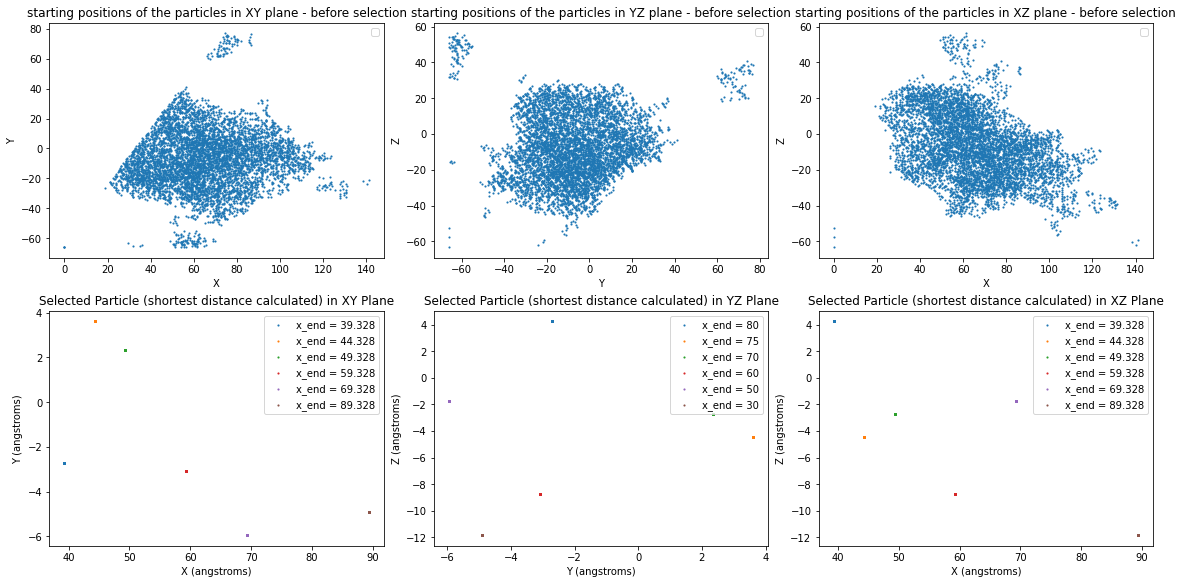

In [445]:
# Create the subplots
x_values = [x_start - x for x in datainit_cut['x'].values]

fig, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)

# Initial plots
axes[0,0].scatter(x_values, datainit_cut['y'].values, s = 5, marker = '.')
axes[0,0].set_title('starting positions of the particles in XY plane - before selection')
axes[0,0].set_xlabel('X')
axes[0,0].set_ylabel('Y')

axes[0,1].scatter(datainit_cut['y'].values, datainit_cut['z'].values, s = 5, marker = '.')
axes[0,1].set_title('starting positions of the particles in YZ plane - before selection')
axes[0,1].set_xlabel('Y')
axes[0,1].set_ylabel('Z')

axes[0,2].scatter(x_values, datainit_cut['z'].values, s = 5, marker = '.')
axes[0,2].set_title('starting positions of the particles in XZ plane - before selection')
axes[0,2].set_xlabel('X')
axes[0,2].set_ylabel('Z')

# Plot results from find_spacing function
for i, (y_vals, z_vals, d_vals) in enumerate(zip(attempty, attemptz, attemptdist)): 
    x_end_options = [80, 75, 70, 60, 50, 30]
    x_values = [x_start - x for x in x_end_options]
    # Ensure label is passed correctly
    axes[1,0].invert_xaxis()
    axes[1,0].scatter([x_values[i]] * len(y_vals), y_vals, s=5, marker='.', label=f"x_end = {x_values[i]}")
    axes[1,1].scatter(y_vals, z_vals, s=5, marker='.', label=f"x_end = {x_end_options[i]}")
    #axes[1,2].scatter([x_end_options[i]] * len(z_vals), z_vals, s=5, marker='.', label=f"x_end = {x_end_options[i]}")
    axes[1,2].invert_xaxis()
    axes[1,2].scatter([x_values[i]] * len(z_vals), z_vals, s=5, marker='.', label=f"x_end = {x_values[i]}")
    
    
# Set plot titles and labels
    axes[1,0].set_title('Selected Particle (shortest distance calculated) in XY Plane')
    axes[1,0].set_xlabel('X (angstroms)')
    axes[1,0].set_ylabel('Y (angstroms)')

    axes[1,1].set_title('Selected Particle (shortest distance calculated) in YZ Plane')
    axes[1,1].set_xlabel('Y (angstroms)')
    axes[1,1].set_ylabel('Z (angstroms)')

    axes[1,2].set_title('Selected Particle (shortest distance calculated) in XZ Plane')
    axes[1,2].set_xlabel('X (angstroms)')
    axes[1,2].set_ylabel('Z (angstroms)')

# Add legends after plotting all the data
for ax in axes.flat:
    ax.legend(loc='best')

### Step 8: Recreate the irradiated gold sample plot with error bars to find track width vs depth

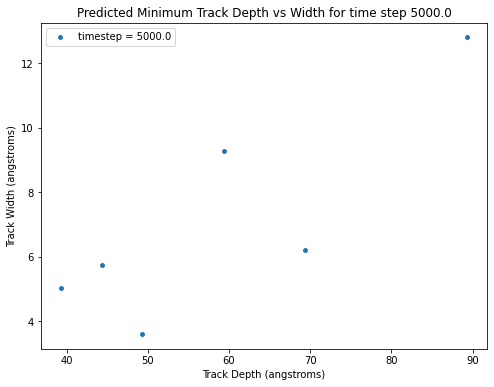

In [453]:
attemptdist = np.array(attemptdist).flatten()
attempterr = np.array(attempterr).flatten()

x_end_options = [80, 75, 70, 60, 50, 30]
x_values = [x_start - x for x in x_end_options]

fig = plt.figure(figsize=(8, 6))
plt.scatter(x_values, attemptdist, label = f'timestep = {steps[0]}', s = 15)
#plt.errorbar(x_values, attemptdist, yerr=attempterr, fmt='o', color='red', markersize=2, label="Error")
plt.title(f'Predicted Minimum Track Depth vs Width for time step {steps[0]}')
plt.xlabel('Track Depth (angstroms)')
plt.ylabel('Track Width (angstroms)')
plt.legend(loc = 'best')

In [426]:
attempterr

array([19.13042154, 19.25105763, 19.28030634, 18.91471829, 19.85408118,
       18.95840319])

### Step 9: Ensure there aren't discrepencies between vacancy density calculations and track width calculations

In [ ]:
'''
this is a potential final sanity check to do once simulation is better
'''